In [1]:
import matplotlib.pyplot as plt
from typing import Iterable
import numpy as np
from matplotlib.animation import FuncAnimation
import random
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from pymoo.core.problem import Problem
import plotly.graph_objects as go
import seaborn as sns
import pandas as pd
from IPython.display import HTML

In [2]:
def mw7(x):
    g = 1 + 9 * np.sum(x[1:]) / (len(x) - 1)
    f1 = x[0]
    f2 = g * (1 - (f1 / g)**0.5)
    c1 = np.sum(x) - 1.5
    c2 = 0.5 - np.sum(x[:-1])
    return [f1, f2], [c1, c2]

def penalized_mw7(x):
    """
    Wrapper function for MW7 that incorporates constraints using penalty method.
    Returns modified fitness values with penalties for constraint violations.
    """
    # Get original objectives and constraints
    [f1, f2], [c1, c2] = mw7(x)
    
    # Calculate constraint violations
    # c1: sum(x) - 1.5 <= 0
    # c2: 0.5 - sum(x[:-1]) <= 0

    scaled_c1 = c1 / 1.5  # Normalize c1 by its max value
    scaled_c2 = c2 / 0.5  # Normalize c2 by its max value

    violation1 = max(0, scaled_c1) # Only penalize if > 0
    violation2 = max(0, scaled_c2) # Only penalize if > 0
    
    # Penalty coefficient (you may need to tune this)
    penalty_coef = 10 * np.max([abs(f1), abs(f2)])
    penalty = penalty_coef * (violation1 + violation2)

    # Add penalties to objectives
    penalized_f1 = f1 + penalty
    penalized_f2 = f2 + penalty
    
    return np.array([penalized_f1, penalized_f2])

In [3]:
class Animation():
    def __init__(self, problem, GENERATIONS: int, IND_PER_GENERATION: int):
        self.problem = problem
        self.GENERATIONS = GENERATIONS
        self.IND_PER_GENERATION = IND_PER_GENERATION
        self.scores = {}

    def evolve_step_by_step(self, evolutive) -> pd.DataFrame:
        if self.problem.name() == 'MW7':
            for idx, _ in enumerate(range(int(self.GENERATIONS/self.IND_PER_GENERATION)), 1):
                if idx == 1:
                    res = evolutive.evolve(fit=penalized_mw7, n_generations=self.IND_PER_GENERATION, trace=10, obtain_metrics=True)
                    fit_scores = np.array([mw7(p)[0] for p in res["best"]])
                    self.scores[idx] = fit_scores
                else:
                    res = evolutive.evolve(fit=penalized_mw7, n_generations=self.IND_PER_GENERATION, trace=10, obtain_metrics=True, seed_population=res["best_cromosome"] + res["population"])
                    fit_scores = np.array([mw7(p)[0] for p in res["best"]])
                    self.scores[idx] = fit_scores
                print('--------------')
        else:
            for idx, _ in enumerate(range(int(self.GENERATIONS/self.IND_PER_GENERATION)), 1):
                if idx == 1:
                    res = evolutive.evolve(fit=self.problem.evaluate, n_generations=self.IND_PER_GENERATION, trace=10, obtain_metrics=True)
                    fit_scores = np.array([self.problem.evaluate(p) for p in res["best"]])
                    self.scores[idx] = fit_scores
                else:
                    res = evolutive.evolve(fit=self.problem.evaluate, n_generations=self.IND_PER_GENERATION, trace=10, obtain_metrics=True, seed_population=res["best_cromosome"] + res["population"])
                    fit_scores = np.array([self.problem.evaluate(p) for p in res["best"]])
                    self.scores[idx] = fit_scores
                print('--------------')

        rows = []
        for key, array in self.scores.items():
            for row in array:
                rows.append({"Generacion": key * self.IND_PER_GENERATION, "X": row[0], "Y": row[1]})

        return self.get_animation(pd.DataFrame(rows))
    
    def get_animation(self, df):

        pareto = self.problem.pareto_front()

        fig, ax = plt.subplots()

        # Dibujar los puntos iniciales del Pareto
        ax.scatter(pareto[:, 0], pareto[:, 1], label='pareto', color='blue')

        # Crear el scatter plot vacío para los puntos animados
        scatter_anim = ax.scatter([], [], label='obtained', color='red')

        ax.legend()

        # Acumular puntos a medida que se avanza en la animación
        all_points = []

        # Animar por grupos
        def animar(frame):
            # Seleccionamos el grupo correspondiente al frame
            grupo = frame + 1
            data_grupo = df[df["Generacion"] == grupo * self.IND_PER_GENERATION]
            scatter_anim.set_offsets(data_grupo[["X", "Y"]].values)  # Actualiza los puntos
            # if grupo == 0:
            #     ax.set_title(f'Generación {(grupo +1) * IND_PER_GENERATION}', fontsize=14)
            # else:
            ax.set_title(f'Generación {grupo * self.IND_PER_GENERATION}', fontsize=14)

        # Crear la animación
        n_frames = df["Generacion"].nunique()  # Total de grupos

        return FuncAnimation(fig, animar, frames=n_frames, repeat=False, interval=750)

In [4]:
from src.multi_evolutive import RealMultiEvolutive
from pymoo.problems import get_problem
from pymoo.util.plotting import plot
import matplotlib.pyplot as plt
import numpy as np
from src.evaluation import MultiObjectiveEvaluation
problem = get_problem("zdt1")
evaluation = MultiObjectiveEvaluation(
    evaluate=problem.evaluate,
    problem=problem,
    reference_point=(1., 1.),
    limits=[[0, 1], [0, 1]]
)
evolutive = RealMultiEvolutive(
    n_individuals=200,
    value_range=[0, 1],
    maximize=[False, False],
    cromolength=30,
    mutation=["random-range", "random-local"],
    crossover=["blx", "uniform", "blx-alpha"],
    front='range',
    penalization='crowding_norm',
    selection_pool_size=0.9,
    average_mutation_rate=1.25,
    mutation_eps=0.5,
    elitism=True,
    alpha=0.2,
    T_selection=6,
    evaluation_metrics=evaluation
)

Generation       10 | Population Elite Points:       48 | Zitlerd: 0.0000 | Spa: 0.0000 | Hrs: 0.0000 | Gdplus: 0.0000 | Igdplus: 0.0000 | Hv: 0.0000
Generation       20 | Population Elite Points:      147 | Zitlerd: 0.0000 | Spa: 0.0000 | Hrs: 0.0000 | Gdplus: 0.0000 | Igdplus: 0.0000 | Hv: 0.0000
--------------
Generation       10 | Population Elite Points:      693 | Zitlerd: 0.5968 | Spa: 0.0412 | Hrs: 0.6326 | Gdplus: 0.5674 | Igdplus: 0.5741 | Hv: 0.0782
Generation       20 | Population Elite Points:     1203 | Zitlerd: 0.5672 | Spa: 0.0269 | Hrs: 0.1403 | Gdplus: 0.2767 | Igdplus: 0.2536 | Hv: 0.3165
--------------
Generation       10 | Population Elite Points:     1458 | Zitlerd: 0.6196 | Spa: 0.0141 | Hrs: 0.1366 | Gdplus: 0.1305 | Igdplus: 0.1204 | Hv: 0.4834
Generation       20 | Population Elite Points:     1625 | Zitlerd: 0.7774 | Spa: 0.0098 | Hrs: 0.0655 | Gdplus: 0.0694 | Igdplus: 0.0648 | Hv: 0.5646
--------------
Generation       10 | Population Elite Points:     1790

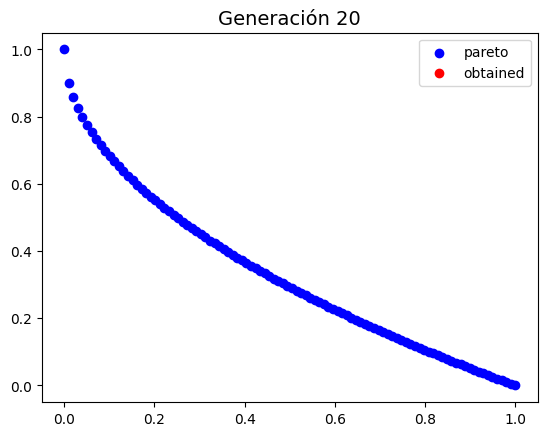

In [5]:
GENERATIONS = 200
IND_PER_GENERATION = 20

animation = Animation(problem, GENERATIONS, IND_PER_GENERATION)

anim = animation.evolve_step_by_step(evolutive)

HTML(anim.to_html5_video())

In [6]:
problem = get_problem("zdt3")
evolutive = RealMultiEvolutive(
    n_individuals=50,
    value_range=[0, 1],
    maximize=[False, False],
    cromolength=30,
    mutation=["random-range", "random-local"],
    crossover=["blx", "uniform", "blx-alpha"],
    front='front',
    penalization='crowding_norm',
    selection_pool_size=0.8,
    average_mutation_rate=1.5,
    mutation_eps=0.5,
    elitism=True,
    alpha=0.6,
    T_selection=10
)

Generation       10 | Population Elite Points:       84 | Best Fit: 1.3859 | Mean Fit: 0.0969
Generation       20 | Population Elite Points:      171 | Best Fit: 1.1697 | Mean Fit: 0.0401
--------------
Generation       10 | Population Elite Points:      289 | Best Fit: 1.1245 | Mean Fit: 0.0231
Generation       20 | Population Elite Points:      357 | Best Fit: 1.1150 | Mean Fit: 0.0187
--------------
Generation       10 | Population Elite Points:      458 | Best Fit: 1.0848 | Mean Fit: 0.0142
Generation       20 | Population Elite Points:      538 | Best Fit: 1.0579 | Mean Fit: 0.0118
--------------
Generation       10 | Population Elite Points:      667 | Best Fit: 1.0514 | Mean Fit: 0.0095
Generation       20 | Population Elite Points:      713 | Best Fit: 1.0536 | Mean Fit: 0.0088
--------------
Generation       10 | Population Elite Points:      773 | Best Fit: 1.0494 | Mean Fit: 0.0068
Generation       20 | Population Elite Points:      835 | Best Fit: 1.0403 | Mean Fit: 0.0075


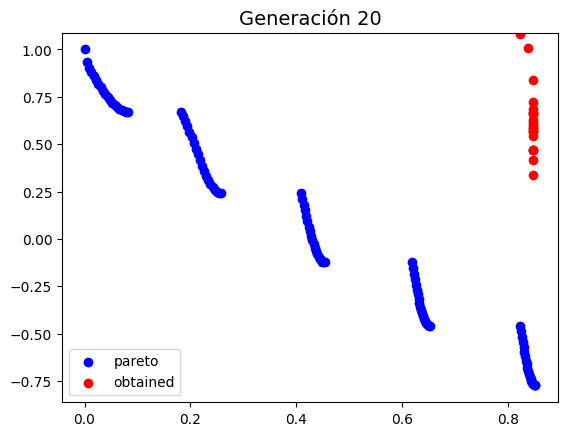

In [7]:
GENERATIONS = 200
IND_PER_GENERATION = 20

animation = Animation(problem, GENERATIONS, IND_PER_GENERATION)

anim = animation.evolve_step_by_step(evolutive)

HTML(anim.to_html5_video())

In [8]:
problem = get_problem("mw7")
evolutive = RealMultiEvolutive(
    n_individuals=20,
    value_range=[0, 1],
    maximize=[False, False],
    cromolength=15,
    mutation=["random-range", "random-local"],
    crossover=["blx", "uniform", "blx-alpha"],
    front='range',
    selection_pool_size=0.8,
    average_mutation_rate=1.5,
    mutation_eps=0.05,
    elitism=True,
    alpha=0.3,
    T_selection=8
)

c:\Users\alexm\Escritorio\UNIVERSIDAD\MASTER\ALG_BIOINSPIRADOS\ALG_EVOLUTIVOS\bioinspired-evo\src\utils.py:60: RuntimeWarning: divide by zero encountered in divide
  norm_points = norm_points = points / (points[p_front1].max(axis=0) - points[p_front1].min(axis=0))
c:\Users\alexm\Escritorio\UNIVERSIDAD\MASTER\ALG_BIOINSPIRADOS\ALG_EVOLUTIVOS\bioinspired-evo\src\utils.py:55: RuntimeWarning: invalid value encountered in subtract
  d_matrix[idx, idx + 1:] = np.sqrt(np.sum((points[idx + 1:] - point)**2, axis=1))


Generation       10 | Population Elite Points:        2 | Best Fit: 2.8615 | Mean Fit: 2.8615
Generation       20 | Population Elite Points:        1 | Best Fit: 2.9545 | Mean Fit: 2.9545
Generation       30 | Population Elite Points:        9 | Best Fit: 1.0498 | Mean Fit: 0.5580
Generation       40 | Population Elite Points:       63 | Best Fit: 0.0818 | Mean Fit: 0.0531
Generation       50 | Population Elite Points:       99 | Best Fit: 0.0403 | Mean Fit: 0.0338
--------------
Generation       10 | Population Elite Points:      152 | Best Fit: 0.0235 | Mean Fit: 0.0215
Generation       20 | Population Elite Points:      125 | Best Fit: 0.0716 | Mean Fit: 0.0261
Generation       30 | Population Elite Points:      141 | Best Fit: 0.0312 | Mean Fit: 0.0219
Generation       40 | Population Elite Points:      194 | Best Fit: 0.0166 | Mean Fit: 0.0152
Generation       50 | Population Elite Points:      265 | Best Fit: 0.0122 | Mean Fit: 0.0112
--------------
Generation       10 | Populati

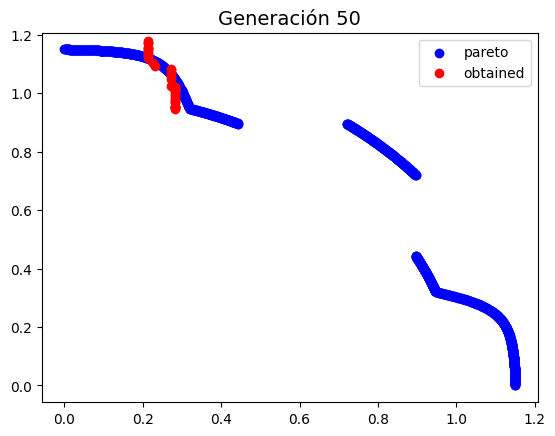

In [9]:
GENERATIONS = 500
IND_PER_GENERATION = 50

animation = Animation(problem, GENERATIONS, IND_PER_GENERATION)

anim = animation.evolve_step_by_step(evolutive)

HTML(anim.to_html5_video())

In [10]:
class TSPProblem(Problem):
    def __init__(self, n_cities, seed=50):
        # Define the number of variables (cities) and objectives (time and distance)
        super().__init__(n_var=n_cities, n_obj=2, n_constr=0, xl=0, xu=1)
        
        # Initialize the random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
        
        # Generate random distances and times between cities
        self.distances = np.random.uniform(0, 100, size=(n_cities, n_cities))
        self.distances = (self.distances + self.distances.T) / 2
        self.times = np.random.uniform(0, 300, size=(n_cities, n_cities))
        random.seed(None)
        
        # Ensure the diagonal is zero (distance/time from a city to itself is zero)
        np.fill_diagonal(self.distances, 0)
        np.fill_diagonal(self.times, 0)

    def _evaluate(self, x, out, *args, **kwargs):
        # Calculate the total distance and time for each solution in x
        distances = []
        times = []
        
        for route in x:
            perm = np.argsort(route)
            total_distance = 0
            total_time = 0
            
            for i in range(len(perm) - 1):
                total_distance += self.distances[perm[i], perm[i+1]]
                total_time += self.times[perm[i], perm[i+1]]
            
            # Add distance and time from last city back to the first city
            total_distance += self.distances[perm[-1], perm[0]]
            total_time += self.times[perm[-1], perm[0]]
            
            distances.append(total_distance)
            times.append(total_time)
        
        out["F"] = np.column_stack([distances, times])

In [12]:
from src.multi_evolutive import PermutationMultiEvolutive
import matplotlib.pyplot as plt

problem_tsp = TSPProblem(100)

evolutive = PermutationMultiEvolutive(
    alphabet=range(100),
    n_individuals=50,
    cromolength=100,
    mutation=["to-opt", "insert-gene", "swap-gene"],
    crossover= ["uniform", "split-merge"],
    front='front',
    penalization='crowding_norm',
    selection_pool=['best', 'section'],
	T_selection=20,
	p_crossover=0.7,
	average_mutation_rate=1.25,
    maximize=[False, False],
    selection_pool_size=1.5,
	elitism=True
)

Generation       10 | Population Elite Points:       18 | Best Fit: 1.9223 | Mean Fit: 0.4082
Generation       20 | Population Elite Points:       28 | Best Fit: 1.6955 | Mean Fit: 0.3565
Generation       30 | Population Elite Points:       26 | Best Fit: 1.7135 | Mean Fit: 0.3440
Generation       40 | Population Elite Points:       35 | Best Fit: 1.7423 | Mean Fit: 0.2444
Generation       50 | Population Elite Points:       35 | Best Fit: 1.5350 | Mean Fit: 0.2699
--------------
Generation       10 | Population Elite Points:       34 | Best Fit: 1.6185 | Mean Fit: 0.2946
Generation       20 | Population Elite Points:       31 | Best Fit: 1.7601 | Mean Fit: 0.2759
Generation       30 | Population Elite Points:       38 | Best Fit: 1.7448 | Mean Fit: 0.2635
Generation       40 | Population Elite Points:       36 | Best Fit: 1.6343 | Mean Fit: 0.2776
Generation       50 | Population Elite Points:       37 | Best Fit: 1.6576 | Mean Fit: 0.2680
--------------
Generation       10 | Populati

TypeError: 'NoneType' object is not subscriptable

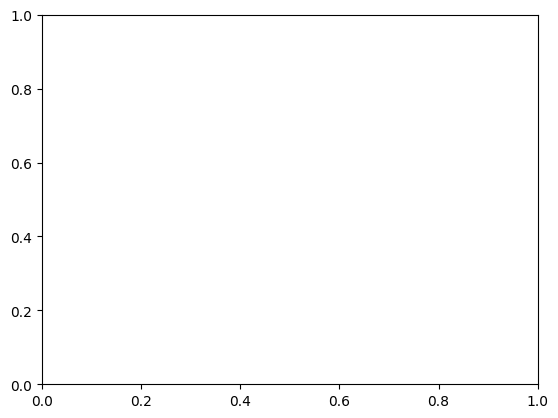

In [14]:
GENERATIONS = 500
IND_PER_GENERATION = 50

animation = Animation(problem_tsp, GENERATIONS, IND_PER_GENERATION)

anim = animation.evolve_step_by_step(evolutive)

HTML(anim.to_html5_video())